### Common imports

In [1]:
import ipywidgets as widgets 
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook
from IPython.display import display

### Gaussian Policy

In [2]:
import sys
import os

sys.path.insert(0, "/home/giuseppe/catkin_ws/devel/lib")

import numpy as np
import matplotlib.pyplot as plt
import pymppi as pys
import time
    
n_inputs = 4

config = pys.Config()
config.horizon = 1.0
config.step_size = 0.01
config.samples = 10
config.filtering = True
config.filters_window = [10] * n_inputs
config.filters_order = [3] * n_inputs
config.variance = [0.01] * n_inputs
config.u_max = [1.0] * n_inputs
config.u_min = [-1.0] * n_inputs

### Utilities

In [3]:
# Utility
def get_samples_data(p):
    tt = p.get_time()
    y_samples = [p.get_sample(tt[0], k) for k in range(config.samples)]
    for t in tt[1:]:
        for k in range(config.samples):
            y_samples[k] = np.vstack((y_samples[k], p.get_sample(t, k)))
    return tt, y_samples

def get_nominal_data(p):
    tt = p.get_time()
    tt = np.arange(tt[0], tt[-1], 0.001)
    y_nominal = p.get(tt[0])
    
    for t in tt[1:]:
        y_nominal = np.vstack((y_nominal, policy.get(t)))
    return tt, y_nominal

def get_exact_nominal_data(p):
    tt = p.get_time()
    y_nominal = p.get(tt[0])
    
    for t in tt[1:]:
        y_nominal = np.vstack((y_nominal, policy.get(t)))
    return tt, y_nominal

### Plot policy

<IPython.core.display.Javascript object>


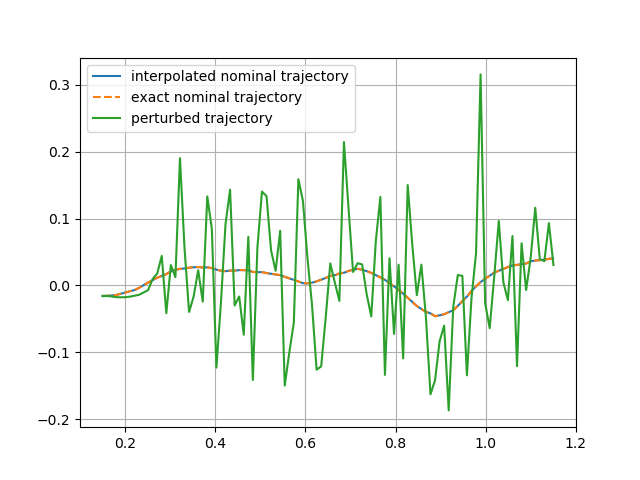

interactive(children=(IntSlider(value=0, description='s', max=9), IntSlider(value=0, description='nu', max=3),…

interactive(children=(IntSlider(value=0, description='delay', max=10), Output()), _dom_classes=('widget-intera…

In [4]:
policy = pys.GaussianPolicy(n_inputs, config)

weights = np.ones(config.samples)
keep = 0
policy.update_samples(weights, 0)

# Assign maximum weight to the first sample
weights = np.zeros(config.samples)
weights[0] = 1.0

time = policy.get_time()
delta_time = 0.011
sample = 0
channel = 0
only_nom = False

fig, ax = plt.subplots()
    
@widgets.interact(s=(0, config.samples-1), nu=(0, n_inputs-1), show_all=False, only_nominal=False)
def show_samples(s=0, nu=0, show_all=False, only_nominal=False):
    global ax1
    global sample
    global only_nom
    only_nom = only_nominal
    sample = s
    channel = nu
    
    # get new data (if updated)
    ts, ys = get_samples_data(policy)
    tn, yn = get_nominal_data(policy)
    te, ye = get_exact_nominal_data(policy)
    
    
    
    ax.clear()
    ax.plot(tn, yn[:, channel], label="interpolated nominal trajectory")
    ax.plot(te, ye[:, channel], '--', label="exact nominal trajectory")
    
    if not only_nominal:
        if not show_all:
            ax.plot(ts, ys[sample][:, channel], label="perturbed trajectory")
        else:
            for i in range(config.samples):
                ax.plot(ts, ys[i][:, channel], '--')
        
    ax.grid()
    ax.legend()

@widgets.interact(delay=(0, 10))
def update_delay(delay=0):
    policy.update_delay(delay)

    
def update_samples(btn):
    global y_samples
    policy.update_samples(weights, keep)
    show_samples(sample, channel, False, only_nom)

t0=0.0
def shift_samples(btn):
    global t0
    t0 += delta_time
    policy.shift(t0)
    show_samples(sample, channel, False, only_nom)

def update_policy(btn):
    global y_samples
    global y_nominal
    step_size = 0.1
    policy.update(weights, step_size)
    show_samples(sample, channel, False, only_nom)


    
update_samples_button = widgets.Button(description="update samples")
update_samples_button.on_click(update_samples)

shift_samples_button = widgets.Button(description="shift samples")
shift_samples_button.on_click(shift_samples)

update_policy_button = widgets.Button(description="update policy")
update_policy_button.on_click(update_policy)

buttons = widgets.HBox([update_samples_button, shift_samples_button, update_policy_button])
display(buttons)   